#Unsupervised Learning

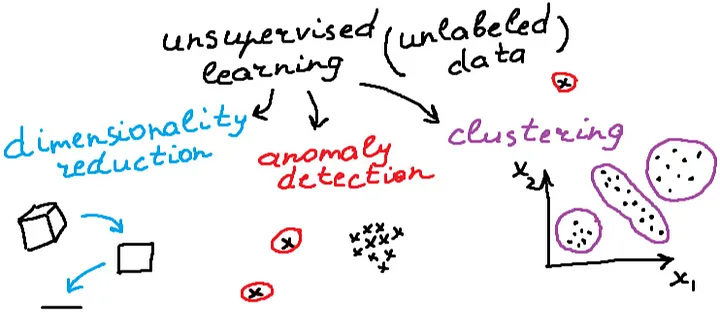

###KMeans Clustering

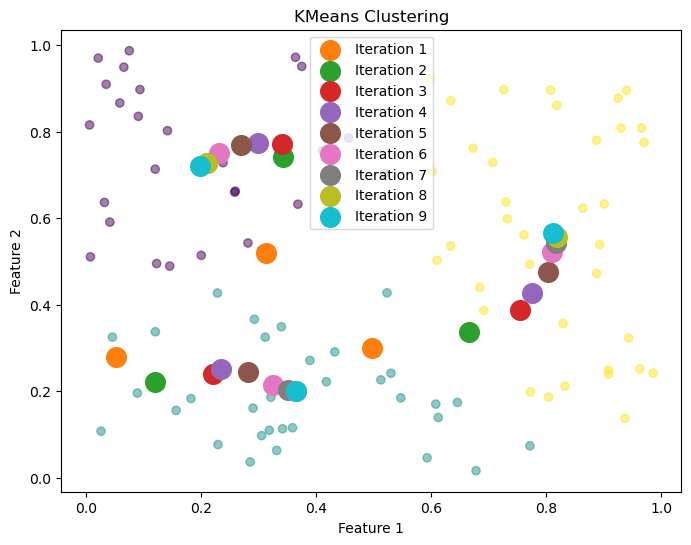

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class KMeans:
    def __init__(self, n_clusters=8, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):
        # Initialize centroids randomly
        self.centroids = X[np.random.choice(range(len(X)), self.n_clusters), :]
        self.centroids_history = [self.centroids]  # save initial centroids
        
        # Iterate until convergence or max_iter
        for i in range(self.max_iter):
            # Assign each data point to the nearest centroid
            labels = self._assign_labels(X, self.centroids)
            
            # Update centroids based on the new cluster assignments
            new_centroids = self._update_centroids(X, labels)
            
            # Check for convergence
            if np.allclose(self.centroids, new_centroids):
                break
            
            # Update centroids
            self.centroids = new_centroids
            
            # Save centroids at each iteration
            self.centroids_history.append(self.centroids)
        
        # Save the cluster labels and final centroids
        self.labels_ = labels
        self.centroids_ = self.centroids
        
        return self
        
    def _assign_labels(self, X, centroids):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        return labels
    
    def _update_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            centroids[i] = X[labels == i].mean(axis=0)
        return centroids

# Generate a random dataset of 100 points in 2D
np.random.seed(42)
X = np.random.rand(100, 2)

# Run KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, max_iter=100)
kmeans.fit(X)

# Plot the data points and centroids at each iteration
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)

for i, centroids in enumerate(kmeans.centroids_history):
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=200, c=f"C{i+1}", label=f"Iteration {i+1}")
    
ax.set_title("KMeans Clustering")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()
plt.show()


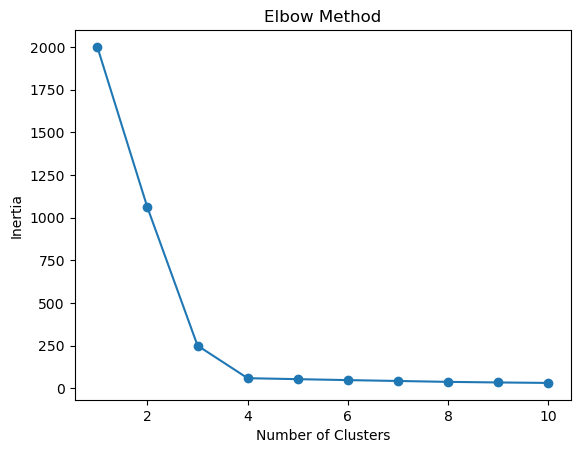

Best parameters: {'kmeans__max_iter': 100, 'kmeans__n_clusters': 6, 'kmeans__tol': 0.001}
Best score: -10.04723378686277


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Generate a random dataset of 1000 points in 2D
X, y = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=42)

# Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find the optimal number of clusters using the elbow method
inertias = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(range(1, 11), inertias, marker='o')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Inertia")
ax.set_title("Elbow Method")
plt.show()

# Optimize the K-means model with hyperparameter tuning
kmeans = KMeans(random_state=42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', kmeans)
])
params = {
    'kmeans__n_clusters': range(2, 7),
    'kmeans__max_iter': [100, 200, 300],
    'kmeans__tol': [1e-3, 1e-4, 1e-5]
}
grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1)
grid_search.fit(X)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


###Hierarchical clustering

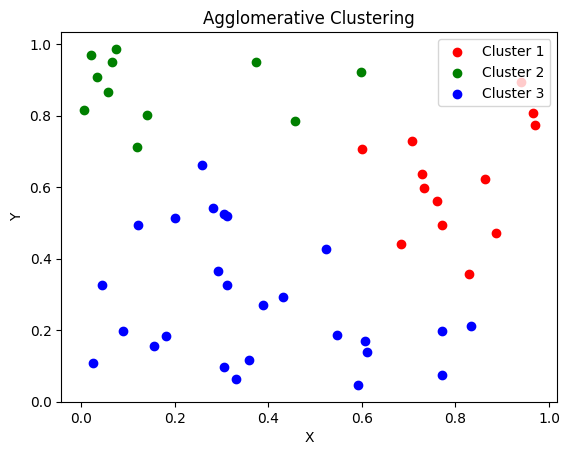

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Euclidean distance
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# Find closest clusters
def find_closest_clusters(clusters):
    min_distance = float("inf")
    closest_clusters = None

    for i, cluster1 in enumerate(clusters):
        for j, cluster2 in enumerate(clusters):
            if i == j:
                continue

            distance = euclidean_distance(cluster1['centroid'], cluster2['centroid'])
            if distance < min_distance:
                min_distance = distance
                closest_clusters = (i, j)

    return closest_clusters

# Update centroid
def update_centroid(cluster):
    new_centroid = np.mean(cluster['points'], axis=0)
    cluster['centroid'] = new_centroid
    return cluster

# Agglomerative Clustering
def agglomerative_clustering(data, n_clusters):
    clusters = [{'centroid': point, 'points': [point]} for point in data]

    while len(clusters) > n_clusters:
        i, j = find_closest_clusters(clusters)
        merged_cluster = {
            'centroid': None,
            'points': clusters[i]['points'] + clusters[j]['points']
        }
        merged_cluster = update_centroid(merged_cluster)

        clusters.pop(j)
        clusters.pop(i)
        clusters.append(merged_cluster)

    return clusters

# Generate sample data
np.random.seed(42)
data = np.random.rand(50, 2)

# Perform Agglomerative Clustering
n_clusters = 3
clusters = agglomerative_clustering(data, n_clusters)

# Visualize clusters
colors = ['r', 'g', 'b']
for i, cluster in enumerate(clusters):
    cluster_points = np.array(cluster['points'])
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'Cluster {i+1}')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Agglomerative Clustering')
plt.show()


###DBSCAN

Cluster labels: [1, 1, 1, 2, 2, -1]


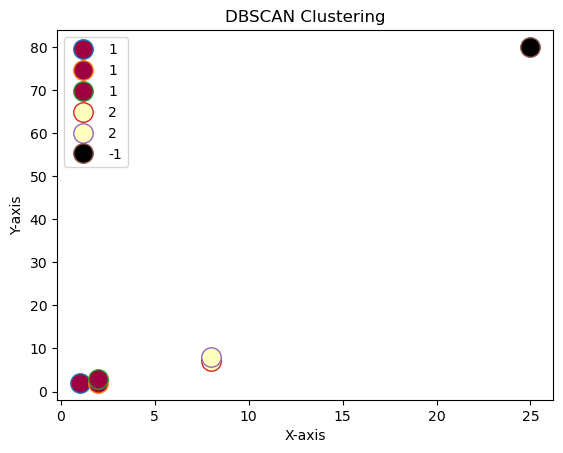

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Sample data
data = np.array([[1, 2], [2, 2], [2, 3], [8, 7], [8, 8], [25, 80]])

# DBSCAN Parameters
eps = 3
min_points = 2

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def find_neighbors(dataset, point_idx, eps):
    neighbors = []
    for i, data_point in enumerate(dataset):
        if euclidean_distance(dataset[point_idx], data_point) < eps:
            neighbors.append(i)
    return neighbors

def dbscan(dataset, eps, min_points):
    labels = [0] * len(dataset)
    cluster_id = 0

    for point_idx, point in enumerate(dataset):
        if labels[point_idx] != 0:
            continue

        neighbors = find_neighbors(dataset, point_idx, eps)

        if len(neighbors) < min_points:
            labels[point_idx] = -1
        else:
            cluster_id += 1
            labels[point_idx] = cluster_id
            queue = deque(neighbors)
            
            while queue:
                current_point = queue.popleft()

                if labels[current_point] == -1:
                    labels[current_point] = cluster_id

                if labels[current_point] != 0:
                    continue

                labels[current_point] = cluster_id
                point_neighbors = find_neighbors(dataset, current_point, eps)

                if len(point_neighbors) >= min_points:
                    queue.extend(point_neighbors)

    return labels

# Running DBSCAN on sample data
labels = dbscan(data, eps, min_points)
print("Cluster labels:", labels)

# Visualizing the results
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = (0, 0, 0, 1)  # Black for noise

    class_members = [idx for idx, l in enumerate(labels) if l == k]
    for idx in class_members:
        plt.plot(data[idx][0], data[idx][1], 'o', markerfacecolor=tuple(col), markersize=14)

plt.title('DBSCAN Clustering')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(labels)
plt.show()


###Principal Component Analysis (PCA) 

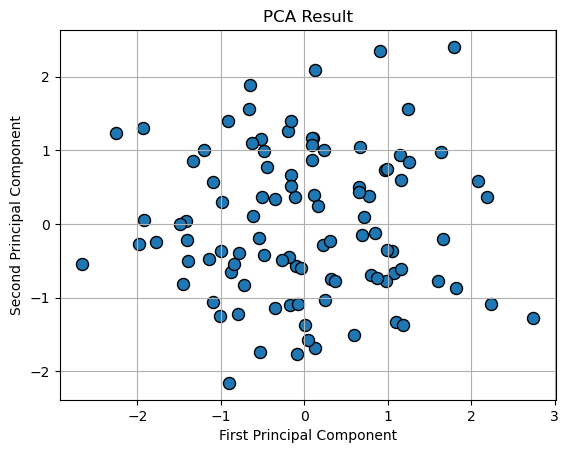

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Standardize the dataset
def standardize_data(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_standardized = (X - mean) / std
    return X_standardized

# Step 2: Compute the covariance matrix
def compute_covariance_matrix(X):
    return np.cov(X.T)

# Step 3: Compute eigenvectors and eigenvalues
def compute_eigen(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    return eigenvalues, eigenvectors

# Step 4: Sort eigenvectors based on eigenvalues
def sort_eigenvectors(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors

# Step 5: Project the data onto the new feature space
def transform_data(X, eigenvectors, n_components):
    W = eigenvectors[:, :n_components]
    return np.dot(X, W)

# PCA function
def pca(X, n_components):
    X_standardized = standardize_data(X)
    cov_matrix = compute_covariance_matrix(X_standardized)
    eigenvalues, eigenvectors = compute_eigen(cov_matrix)
    eigenvalues, eigenvectors = sort_eigenvectors(eigenvalues, eigenvectors)
    return transform_data(X_standardized, eigenvectors, n_components)

# Generate a random dataset
np.random.seed(0)
X = np.random.randn(100, 3)

# Perform PCA
X_pca = pca(X, n_components=2)

# Visualize the results
plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolors='k', s=75)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Result')
plt.grid(True)
plt.show()
